In [1]:
import numpy as np
import matplotlib.pyplot as plt


# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
def set_hnc(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=5, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

# Priority 1

## atom

In [6]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

case_successes = {}
SVT_case_successes = {}
R_max = 
N_bins = 3000
max_attempts=1

tccw_case = tccw_cases[3]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni = tccw_case['Number Density [N/cc]']
Te = tccw_case['Temperature [eV]']*eV
Ti = Te
Z = tccw_case['Atomic Number']
Zstar = tccw_case['Zbar (TFDW)']
A = tccw_case['Atomic Weight [a.u.]']
r_s = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s

print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te/eV, ni, r_c))



______________________________
Case num: 3 Case ID: Cu1
Te = 1.000e+00 eV, n_i = 8.490e+22 1/cc, r_c/r_s = 0.198


In [7]:
c_k_matrix_list = []
h_k_matrix_list = []
atom_list = []
T_max = 20*Te
Te_list = np.linspace(Te, T_max, num=100)[::-1]
alpha_Picard=0.1
for index, Te_annealed in enumerate(Te_list):
    print("\n__________________________\nTe = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te_annealed/eV, ni, r_c))
    atom, atomqsp = set_hnc(ni, Te_annealed, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp')
    
    if index>0:
        atom.h_k_matrix = h_k_matrix_list[-1].copy()#(h_k_matrix_list[-1]-h_k_matrix_list[-2])/(Te_list[index-1]-Te_list[index-])
        atom.c_s_k_matrix  = atom.invert_SVT(atom.h_k_matrix, -atom.βu_s_k_matrix)
        alpha_Picard = 1e-3
    if index>1:
        atom.h_k_matrix = h_k_matrix_list[-1] + (Te_annealed-Te_list[index-1])*(h_k_matrix_list[-1]-h_k_matrix_list[-2])/(Te_list[index-1]-Te_list[index-2])
        atom.c_s_k_matrix  = atom.invert_SVT(atom.h_k_matrix, -atom.βu_s_k_matrix)
        alpha_Picard = 1e-3
    atom.HNC_solve(alpha_method='fixed', alpha_Picard = alpha_Picard, tol=1e-7, alpha_Ng=1e-10, 
                   iters_to_wait=1e4, num_iterations=100)
    atom.HNC_newton_solve(method='krylov', rdiff=1e-8, num_iterations=50, tol=1e-6)
#     if atom.newton_succeed==False:
#         break
    atom_list.append(atom)
    c_k_matrix_list.append(atom.c_k_matrix.copy())
    h_k_matrix_list.append(atom.h_k_matrix.copy())


__________________________
Te = 2.000e+01 eV, n_i = 8.490e+22 1/cc, r_c/r_s = 0.198
Λei = 0.151
Λee = 0.214
Λei adjusted with R = 0.151
Γii=15.078, Γie=-2.085, Γee=0.383 
r_i=2.667
r_e=1.517
r_c=0.198
θ  =9.18e-01
0: Change in c_r: 7.567e-03, HNC Error: 3.659e+05, Total Error: 1.556e+02
1: Change in c_r: 7.257e-03, HNC Error: 3.048e+03, Total Error: 1.402e+02
2: Change in c_r: 7.039e-03, HNC Error: 1.693e+02, Total Error: 1.264e+02
3: Change in c_r: 6.857e-03, HNC Error: 2.645e+01, Total Error: 1.140e+02
4: Change in c_r: 6.693e-03, HNC Error: 7.588e+00, Total Error: 1.027e+02
5: Change in c_r: 6.541e-03, HNC Error: 3.147e+00, Total Error: 9.259e+01
6: Change in c_r: 6.397e-03, HNC Error: 1.649e+00, Total Error: 8.346e+01
7: Change in c_r: 6.258e-03, HNC Error: 1.016e+00, Total Error: 7.523e+01
8: Change in c_r: 6.125e-03, HNC Error: 7.111e-01, Total Error: 6.782e+01
9: Change in c_r: 5.996e-03, HNC Error: 5.552e-01, Total Error: 6.113e+01
10: Change in c_r: 5.871e-03, HNC Error: 4.77

0: Change in c_r: 1.345e-07, HNC Error: 2.474e-03, Total Error: 1.738e-04
1: Change in c_r: 1.343e-07, HNC Error: 2.460e-03, Total Error: 1.732e-04
2: Change in c_r: 1.342e-07, HNC Error: 2.445e-03, Total Error: 1.725e-04
3: Change in c_r: 1.341e-07, HNC Error: 2.431e-03, Total Error: 1.719e-04
4: Change in c_r: 1.339e-07, HNC Error: 2.417e-03, Total Error: 1.713e-04
5: Change in c_r: 1.338e-07, HNC Error: 2.402e-03, Total Error: 1.706e-04
6: Change in c_r: 1.336e-07, HNC Error: 2.388e-03, Total Error: 1.700e-04
7: Change in c_r: 1.335e-07, HNC Error: 2.373e-03, Total Error: 1.694e-04
8: Change in c_r: 1.334e-07, HNC Error: 2.359e-03, Total Error: 1.687e-04
9: Change in c_r: 1.332e-07, HNC Error: 2.344e-03, Total Error: 1.681e-04
10: Change in c_r: 1.331e-07, HNC Error: 2.330e-03, Total Error: 1.675e-04
11: Change in c_r: 1.330e-07, HNC Error: 2.315e-03, Total Error: 1.668e-04
12: Change in c_r: 1.328e-07, HNC Error: 2.301e-03, Total Error: 1.662e-04
13: Change in c_r: 1.327e-07, HNC E

0: Change in c_r: 1.427e-07, HNC Error: 2.655e-03, Total Error: 1.914e-04
1: Change in c_r: 1.425e-07, HNC Error: 2.639e-03, Total Error: 1.907e-04
2: Change in c_r: 1.424e-07, HNC Error: 2.623e-03, Total Error: 1.900e-04
3: Change in c_r: 1.422e-07, HNC Error: 2.607e-03, Total Error: 1.893e-04
4: Change in c_r: 1.421e-07, HNC Error: 2.590e-03, Total Error: 1.886e-04
5: Change in c_r: 1.419e-07, HNC Error: 2.574e-03, Total Error: 1.879e-04
6: Change in c_r: 1.418e-07, HNC Error: 2.558e-03, Total Error: 1.872e-04
7: Change in c_r: 1.417e-07, HNC Error: 2.542e-03, Total Error: 1.865e-04
8: Change in c_r: 1.415e-07, HNC Error: 2.525e-03, Total Error: 1.858e-04
9: Change in c_r: 1.414e-07, HNC Error: 2.509e-03, Total Error: 1.851e-04
10: Change in c_r: 1.412e-07, HNC Error: 2.493e-03, Total Error: 1.844e-04
11: Change in c_r: 1.411e-07, HNC Error: 2.476e-03, Total Error: 1.837e-04
12: Change in c_r: 1.409e-07, HNC Error: 2.460e-03, Total Error: 1.830e-04
13: Change in c_r: 1.408e-07, HNC E

0: Change in c_r: 1.728e-07, HNC Error: 3.069e-03, Total Error: 2.267e-04
1: Change in c_r: 1.726e-07, HNC Error: 3.051e-03, Total Error: 2.259e-04
2: Change in c_r: 1.725e-07, HNC Error: 3.033e-03, Total Error: 2.252e-04
3: Change in c_r: 1.723e-07, HNC Error: 3.015e-03, Total Error: 2.244e-04
4: Change in c_r: 1.721e-07, HNC Error: 2.997e-03, Total Error: 2.236e-04
5: Change in c_r: 1.720e-07, HNC Error: 2.979e-03, Total Error: 2.228e-04
6: Change in c_r: 1.718e-07, HNC Error: 2.961e-03, Total Error: 2.220e-04
7: Change in c_r: 1.716e-07, HNC Error: 2.943e-03, Total Error: 2.213e-04
8: Change in c_r: 1.714e-07, HNC Error: 2.925e-03, Total Error: 2.205e-04
9: Change in c_r: 1.713e-07, HNC Error: 2.907e-03, Total Error: 2.197e-04
10: Change in c_r: 1.711e-07, HNC Error: 2.889e-03, Total Error: 2.189e-04
11: Change in c_r: 1.709e-07, HNC Error: 2.871e-03, Total Error: 2.182e-04
12: Change in c_r: 1.707e-07, HNC Error: 2.853e-03, Total Error: 2.174e-04
13: Change in c_r: 1.706e-07, HNC E


__________________________
Te = 1.904e+01 eV, n_i = 8.490e+22 1/cc, r_c/r_s = 0.198
Λei = 0.153
Λee = 0.217
Λei adjusted with R = 0.153
Γii=15.838, Γie=-2.142, Γee=0.394 
r_i=2.667
r_e=1.517
r_c=0.198
θ  =8.74e-01
0: Change in c_r: 2.436e-07, HNC Error: 3.858e-03, Total Error: 2.913e-04
1: Change in c_r: 2.433e-07, HNC Error: 3.839e-03, Total Error: 2.904e-04
2: Change in c_r: 2.431e-07, HNC Error: 3.820e-03, Total Error: 2.896e-04
3: Change in c_r: 2.428e-07, HNC Error: 3.800e-03, Total Error: 2.887e-04
4: Change in c_r: 2.426e-07, HNC Error: 3.781e-03, Total Error: 2.878e-04
5: Change in c_r: 2.423e-07, HNC Error: 3.761e-03, Total Error: 2.869e-04
6: Change in c_r: 2.421e-07, HNC Error: 3.742e-03, Total Error: 2.861e-04
7: Change in c_r: 2.418e-07, HNC Error: 3.722e-03, Total Error: 2.852e-04
8: Change in c_r: 2.416e-07, HNC Error: 3.703e-03, Total Error: 2.843e-04
9: Change in c_r: 2.414e-07, HNC Error: 3.683e-03, Total Error: 2.834e-04
10: Change in c_r: 2.411e-07, HNC Error: 3.66

Iter: 6, Newton residual norm: 5.678e-09, Change: 1.199e-08 

Krylov:  True A solution was found at the specified tolerance.

__________________________
Te = 1.885e+01 eV, n_i = 8.490e+22 1/cc, r_c/r_s = 0.198
Λei = 0.154
Λee = 0.217
Λei adjusted with R = 0.154
Γii=15.999, Γie=-2.154, Γee=0.396 
r_i=2.667
r_e=1.517
r_c=0.198
θ  =8.65e-01
0: Change in c_r: 1.108e-07, HNC Error: 2.832e-03, Total Error: 2.578e-04
1: Change in c_r: 1.107e-07, HNC Error: 2.805e-03, Total Error: 2.569e-04
2: Change in c_r: 1.106e-07, HNC Error: 2.778e-03, Total Error: 2.559e-04
3: Change in c_r: 1.105e-07, HNC Error: 2.750e-03, Total Error: 2.550e-04
4: Change in c_r: 1.103e-07, HNC Error: 2.723e-03, Total Error: 2.540e-04
5: Change in c_r: 1.102e-07, HNC Error: 2.696e-03, Total Error: 2.531e-04
6: Change in c_r: 1.101e-07, HNC Error: 2.669e-03, Total Error: 2.522e-04
7: Change in c_r: 1.100e-07, HNC Error: 2.642e-03, Total Error: 2.513e-04
8: Change in c_r: 1.099e-07, HNC Error: 2.615e-03, Total Error: 2.50

0: Change in c_r: 1.449e-07, HNC Error: 3.495e-03, Total Error: 3.369e-04
1: Change in c_r: 1.448e-07, HNC Error: 3.463e-03, Total Error: 3.358e-04
2: Change in c_r: 1.446e-07, HNC Error: 3.430e-03, Total Error: 3.346e-04
3: Change in c_r: 1.445e-07, HNC Error: 3.398e-03, Total Error: 3.335e-04
4: Change in c_r: 1.443e-07, HNC Error: 3.365e-03, Total Error: 3.324e-04
5: Change in c_r: 1.442e-07, HNC Error: 3.333e-03, Total Error: 3.313e-04
6: Change in c_r: 1.440e-07, HNC Error: 3.301e-03, Total Error: 3.302e-04
7: Change in c_r: 1.439e-07, HNC Error: 3.268e-03, Total Error: 3.291e-04
8: Change in c_r: 1.437e-07, HNC Error: 3.236e-03, Total Error: 3.280e-04
9: Change in c_r: 1.436e-07, HNC Error: 3.203e-03, Total Error: 3.269e-04
10: Change in c_r: 1.434e-07, HNC Error: 3.171e-03, Total Error: 3.259e-04
11: Change in c_r: 1.433e-07, HNC Error: 3.138e-03, Total Error: 3.248e-04
12: Change in c_r: 1.431e-07, HNC Error: 3.106e-03, Total Error: 3.237e-04
13: Change in c_r: 1.430e-07, HNC E

0: Change in c_r: 1.752e-07, HNC Error: 4.290e-03, Total Error: 4.593e-04
1: Change in c_r: 1.750e-07, HNC Error: 4.249e-03, Total Error: 4.579e-04
2: Change in c_r: 1.748e-07, HNC Error: 4.207e-03, Total Error: 4.565e-04
3: Change in c_r: 1.746e-07, HNC Error: 4.166e-03, Total Error: 4.551e-04
4: Change in c_r: 1.744e-07, HNC Error: 4.125e-03, Total Error: 4.538e-04
5: Change in c_r: 1.742e-07, HNC Error: 4.083e-03, Total Error: 4.524e-04
6: Change in c_r: 1.741e-07, HNC Error: 4.042e-03, Total Error: 4.511e-04
7: Change in c_r: 1.739e-07, HNC Error: 4.001e-03, Total Error: 4.498e-04
8: Change in c_r: 1.737e-07, HNC Error: 3.960e-03, Total Error: 4.485e-04
9: Change in c_r: 1.735e-07, HNC Error: 3.918e-03, Total Error: 4.472e-04
10: Change in c_r: 1.733e-07, HNC Error: 3.877e-03, Total Error: 4.459e-04
11: Change in c_r: 1.731e-07, HNC Error: 3.836e-03, Total Error: 4.446e-04
12: Change in c_r: 1.730e-07, HNC Error: 3.795e-03, Total Error: 4.433e-04
13: Change in c_r: 1.728e-07, HNC E

3: Change in c_r: 1.481e-07, HNC Error: 5.236e-03, Total Error: 6.878e-04
4: Change in c_r: 1.480e-07, HNC Error: 5.179e-03, Total Error: 6.861e-04
5: Change in c_r: 1.478e-07, HNC Error: 5.122e-03, Total Error: 6.844e-04
6: Change in c_r: 1.476e-07, HNC Error: 5.065e-03, Total Error: 6.827e-04
7: Change in c_r: 1.475e-07, HNC Error: 5.008e-03, Total Error: 6.810e-04
8: Change in c_r: 1.473e-07, HNC Error: 4.951e-03, Total Error: 6.794e-04
9: Change in c_r: 1.471e-07, HNC Error: 4.895e-03, Total Error: 6.778e-04
10: Change in c_r: 1.470e-07, HNC Error: 4.839e-03, Total Error: 6.761e-04
11: Change in c_r: 1.468e-07, HNC Error: 4.783e-03, Total Error: 6.745e-04
12: Change in c_r: 1.466e-07, HNC Error: 4.728e-03, Total Error: 6.730e-04
13: Change in c_r: 1.465e-07, HNC Error: 4.673e-03, Total Error: 6.714e-04
14: Change in c_r: 1.463e-07, HNC Error: 4.618e-03, Total Error: 6.698e-04
15: Change in c_r: 1.461e-07, HNC Error: 4.563e-03, Total Error: 6.683e-04
16: Change in c_r: 1.460e-07, HN

18: Change in c_r: 1.590e-07, HNC Error: 8.077e-03, Total Error: 1.417e-03
19: Change in c_r: 1.588e-07, HNC Error: 7.986e-03, Total Error: 1.414e-03
20: Change in c_r: 1.586e-07, HNC Error: 7.896e-03, Total Error: 1.412e-03
21: Change in c_r: 1.584e-07, HNC Error: 7.807e-03, Total Error: 1.409e-03
22: Change in c_r: 1.582e-07, HNC Error: 7.719e-03, Total Error: 1.407e-03
23: Change in c_r: 1.580e-07, HNC Error: 7.632e-03, Total Error: 1.404e-03
24: Change in c_r: 1.578e-07, HNC Error: 7.547e-03, Total Error: 1.402e-03
25: Change in c_r: 1.576e-07, HNC Error: 7.463e-03, Total Error: 1.400e-03
26: Change in c_r: 1.574e-07, HNC Error: 7.380e-03, Total Error: 1.397e-03
27: Change in c_r: 1.572e-07, HNC Error: 7.299e-03, Total Error: 1.395e-03
28: Change in c_r: 1.570e-07, HNC Error: 7.220e-03, Total Error: 1.393e-03
29: Change in c_r: 1.568e-07, HNC Error: 7.142e-03, Total Error: 1.390e-03
30: Change in c_r: 1.566e-07, HNC Error: 7.065e-03, Total Error: 1.388e-03
31: Change in c_r: 1.564e

/home/zach/plasma/hnc/hnc_Ng.py:309: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )


Iter: 43, Newton residual norm: 5.103e+03, Change: 1.448e-02 
Iter: 44, Newton residual norm: 3.462e+03, Change: 8.372e-03 
Iter: 45, Newton residual norm: 4.418e+03, Change: 1.515e-02 
Iter: 46, Newton residual norm: 4.424e+03, Change: 1.587e-04 


/home/zach/plasma/hnc/hnc_Ng.py:323: RuntimeWarning: overflow encountered in exp
  self.h_r_matrix = -1 + np.exp(self.γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


Iter: 47, Newton residual norm: 7.256e+03, Change: 1.564e-02 
Iter: 48, Newton residual norm: 7.259e+03, Change: 7.004e-06 
Iter: 49, Newton residual norm: 7.046e+03, Change: 1.013e-01 
Iter: 50, Newton residual norm: 7.040e+03, Change: 4.511e-03 

Krylov:  False The maximum number of iterations allowed has been reached.


/home/zach/plasma/hnc/hnc_Ng.py:459: RuntimeWarning: overflow encountered in exp
  self.h_r_matrix = -1 + np.exp(self.γs_r_matrix - self.βu_s_r_matrix)



__________________________
Te = 1.789e+01 eV, n_i = 8.490e+22 1/cc, r_c/r_s = 0.198
Λei = 0.156
Λee = 0.220
Λei adjusted with R = 0.156
Γii=16.858, Γie=-2.214, Γee=0.407 
r_i=2.667
r_e=1.517
r_c=0.198
θ  =8.21e-01


/home/zach/plasma/hnc/hnc_Ng.py:410: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc_Ng.py:518: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)
/home/zach/plasma/hnc/hnc_Ng.py:384: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )


0: Change in c_r: 4.594e-01, HNC Error: inf, Total Error: inf
1: Change in c_r: 7.911e-01, HNC Error: inf, Total Error: inf
2: Change in c_r: 7.906e-01, HNC Error: inf, Total Error: inf
3: Change in c_r: 7.930e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 7.914e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 7.917e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 7.909e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.921e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.926e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.926e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.918e-01, HNC Error: inf, Total Error: inf


/home/zach/plasma/hnc/hnc_Ng.py:526: RuntimeWarning: invalid value encountered in subtract
  Δ_err = np.array(self.tot_err_list[-iters_to_check:-2]) - np.array(self.tot_err_list[-iters_to_check + 1:-1])


11: Change in c_r: 7.921e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.168e+03, Change: 7.525e-03 
Iter: 2, Newton residual norm: 7.166e+03, Change: 6.683e-03 
Iter: 3, Newton residual norm: 7.165e+03, Change: 1.330e-03 
Iter: 4, Newton residual norm: 7.164e+03, Change: 2.074e-03 
Iter: 5, Newton residual norm: 7.163e+03, Change: 2.658e-03 
Iter: 6, Newton residual norm: 7.161e+03, Change: 9.418e-03 
Iter: 7, Newton residual norm: 7.159e+03, Change: 2.190e-03 
Iter: 8, Newton residual norm: 7.159e+03, Change: 1.341e-03 
Iter: 9, Newton residual norm: 7.158e+03, Change: 1.377e-03 
Iter: 10, Newton residual norm: 7.166e+03, Change: 1.336e-02 
Iter: 11, Newton residual norm: 7.166e+03, Change: 4.937e-03 
Iter: 12, Newton residual norm: 7.164e+03, Change: 2.262e-03 
Iter: 13, Newton residual norm: 7.164e+03, Change: 6.229e-04 
Iter: 14, Newton residual norm: 7.200e+03, Change: 1.370e-02 
Iter: 15, Newton residual norm: 7.189e+03, Change:

10: Change in c_r: 8.009e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.171e+03, Change: 1.217e-02 
Iter: 2, Newton residual norm: 7.168e+03, Change: 7.695e-03 
Iter: 3, Newton residual norm: 7.168e+03, Change: 3.227e-03 
Iter: 4, Newton residual norm: 7.167e+03, Change: 3.020e-03 
Iter: 5, Newton residual norm: 7.166e+03, Change: 2.159e-03 
Iter: 6, Newton residual norm: 7.166e+03, Change: 3.516e-03 
Iter: 7, Newton residual norm: 7.166e+03, Change: 1.226e-03 
Iter: 8, Newton residual norm: 7.166e+03, Change: 5.089e-04 
Iter: 9, Newton residual norm: 7.165e+03, Change: 1.620e-03 
Iter: 10, Newton residual norm: 7.165e+03, Change: 2.387e-03 
Iter: 11, Newton residual norm: 7.165e+03, Change: 2.503e-03 
Iter: 12, Newton residual norm: 7.164e+03, Change: 2.180e-03 
Iter: 13, Newton residual norm: 7.164e+03, Change: 2.858e-03 
Iter: 14, Newton residual norm: 7.163e+03, Change

9: Change in c_r: 8.006e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.005e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.003e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.187e+03, Change: 9.767e-03 
Iter: 2, Newton residual norm: 7.186e+03, Change: 2.952e-03 
Iter: 3, Newton residual norm: 7.185e+03, Change: 8.225e-03 
Iter: 4, Newton residual norm: 7.184e+03, Change: 6.538e-03 
Iter: 5, Newton residual norm: 7.184e+03, Change: 2.329e-04 
Iter: 6, Newton residual norm: 7.183e+03, Change: 3.241e-03 
Iter: 7, Newton residual norm: 7.187e+03, Change: 1.123e-02 
Iter: 8, Newton residual norm: 7.186e+03, Change: 5.773e-03 
Iter: 9, Newton residual norm: 7.186e+03, Change: 6.511e-04 
Iter: 10, Newton residual norm: 7.188e+03, Change: 7.381e-03 
Iter: 11, Newton residual norm: 7.184e+03, Change: 8.694e-03 
Iter: 12, Newton residual norm: 7.183e+03, Change: 3.254e-03 
Iter: 13, Newton residual norm: 7.183e+03, Change

8: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.996e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.998e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.997e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.218e+03, Change: 3.389e-03 
Iter: 2, Newton residual norm: 7.218e+03, Change: 6.639e-03 
Iter: 3, Newton residual norm: 7.215e+03, Change: 2.115e-02 
Iter: 4, Newton residual norm: 7.214e+03, Change: 9.412e-03 
Iter: 5, Newton residual norm: 7.213e+03, Change: 1.095e-02 
Iter: 6, Newton residual norm: 7.211e+03, Change: 7.928e-03 
Iter: 7, Newton residual norm: 7.211e+03, Change: 2.995e-03 
Iter: 8, Newton residual norm: 7.210e+03, Change: 8.184e-03 
Iter: 9, Newton residual norm: 7.209e+03, Change: 1.450e-02 
Iter: 10, Newton residual norm: 7.208e+03, Change: 7.066e-03 
Iter: 11, Newton residual norm: 7.208e+03, Change: 1.614e-03 
Iter: 12, Newton residual norm: 7.207e+03, Change

7: Change in c_r: 7.950e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.941e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.944e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.949e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.953e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.164e+03, Change: 7.092e-03 
Iter: 2, Newton residual norm: 7.164e+03, Change: 4.964e-03 
Iter: 3, Newton residual norm: 7.162e+03, Change: 3.670e-03 
Iter: 4, Newton residual norm: 7.161e+03, Change: 4.741e-03 
Iter: 5, Newton residual norm: 7.161e+03, Change: 3.006e-04 
Iter: 6, Newton residual norm: 7.167e+03, Change: 7.052e-03 
Iter: 7, Newton residual norm: 7.161e+03, Change: 4.875e-03 
Iter: 8, Newton residual norm: 7.159e+03, Change: 3.296e-03 
Iter: 9, Newton residual norm: 7.159e+03, Change: 8.165e-04 
Iter: 10, Newton residual norm: 7.193e+03, Change: 3.933e-03 
Iter: 11, Newton residual norm: 7.177e+03, Change

6: Change in c_r: 7.990e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.993e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.987e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.201e+03, Change: 4.580e-03 
Iter: 2, Newton residual norm: 7.199e+03, Change: 7.097e-03 
Iter: 3, Newton residual norm: 7.198e+03, Change: 4.945e-03 
Iter: 4, Newton residual norm: 7.198e+03, Change: 5.478e-04 
Iter: 5, Newton residual norm: 7.198e+03, Change: 1.398e-03 
Iter: 6, Newton residual norm: 7.202e+03, Change: 6.453e-03 
Iter: 7, Newton residual norm: 7.201e+03, Change: 5.455e-03 
Iter: 8, Newton residual norm: 7.198e+03, Change: 5.230e-03 
Iter: 9, Newton residual norm: 7.198e+03, Change: 3.974e-04 
Iter: 10, Newton residual norm: 7.205e+03, Change

5: Change in c_r: 8.023e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 7.995e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.992e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.997e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.999e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.002e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.282e+03, Change: 1.926e-03 
Iter: 2, Newton residual norm: 7.281e+03, Change: 1.509e-02 
Iter: 3, Newton residual norm: 7.280e+03, Change: 3.755e-03 
Iter: 4, Newton residual norm: 7.279e+03, Change: 1.339e-02 
Iter: 5, Newton residual norm: 7.278e+03, Change: 5.876e-03 
Iter: 6, Newton residual norm: 7.291e+03, Change: 8.974e-03 
Iter: 7, Newton residual norm: 7.284e+03, Change: 1.473e-02 
Iter: 8, Newton residual norm: 7.282e+03, Change: 1.135e-02 
Iter: 9, Newton residual norm: 7.280e+03, Change

4: Change in c_r: 7.943e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 7.933e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 7.942e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.922e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.932e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.929e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.936e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.936e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.190e+03, Change: 5.585e-03 
Iter: 2, Newton residual norm: 7.189e+03, Change: 2.720e-03 
Iter: 3, Newton residual norm: 7.188e+03, Change: 4.587e-03 
Iter: 4, Newton residual norm: 7.187e+03, Change: 9.299e-03 
Iter: 5, Newton residual norm: 7.187e+03, Change: 1.751e-03 
Iter: 6, Newton residual norm: 7.186e+03, Change: 1.906e-03 
Iter: 7, Newton residual norm: 7.187e+03, Change: 5.287e-03 
Iter: 8, Newton residual norm: 7.186e+03, Chang

3: Change in c_r: 8.090e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 8.064e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 8.063e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.050e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 8.058e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 8.046e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 8.056e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.056e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.059e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.239e+03, Change: 8.128e-03 
Iter: 2, Newton residual norm: 7.239e+03, Change: 3.204e-03 
Iter: 3, Newton residual norm: 7.239e+03, Change: 3.357e-04 
Iter: 4, Newton residual norm: 7.238e+03, Change: 5.297e-04 
Iter: 5, Newton residual norm: 7.238e+03, Change: 7.830e-04 
Iter: 6, Newton residual norm: 7.238e+03, Change: 1.893e-04 
Iter: 7, Newton residual norm: 7.247e+03, Chan

2: Change in c_r: 7.986e-01, HNC Error: inf, Total Error: inf
3: Change in c_r: 7.932e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 7.996e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 8.004e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.009e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.985e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.985e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.972e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.976e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.969e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.230e+03, Change: 3.918e-04 
Iter: 2, Newton residual norm: 7.228e+03, Change: 6.914e-03 
Iter: 3, Newton residual norm: 7.227e+03, Change: 4.034e-03 
Iter: 4, Newton residual norm: 7.227e+03, Change: 3.033e-04 
Iter: 5, Newton residual norm: 7.239e+03, Change: 1.925e-02 
Iter: 6, Newton residual norm: 7.238e+03, Cha

1: Change in c_r: 7.989e-01, HNC Error: inf, Total Error: inf
2: Change in c_r: 8.018e-01, HNC Error: inf, Total Error: inf
3: Change in c_r: 7.995e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 8.013e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 8.008e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.004e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 8.002e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 8.000e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.999e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.002e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.994e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.145e+03, Change: 6.082e-04 
Iter: 2, Newton residual norm: 7.144e+03, Change: 2.077e-03 
Iter: 3, Newton residual norm: 7.140e+03, Change: 5.265e-03 
Iter: 4, Newton residual norm: 7.148e+03, Change: 1.155e-02 
Iter: 5, Newton residual norm: 7.138e+03, Ch

9: Change in c_r: 8.046e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.040e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.041e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.232e+03, Change: 1.365e-02 
Iter: 2, Newton residual norm: 7.230e+03, Change: 5.432e-03 
Iter: 3, Newton residual norm: 7.225e+03, Change: 1.049e-02 
Iter: 4, Newton residual norm: 7.222e+03, Change: 4.317e-03 
Iter: 5, Newton residual norm: 7.221e+03, Change: 9.598e-04 
Iter: 6, Newton residual norm: 7.221e+03, Change: 3.412e-04 
Iter: 7, Newton residual norm: 7.221e+03, Change: 1.988e-04 
Iter: 8, Newton residual norm: 7.237e+03, Change: 8.642e-03 
Iter: 9, Newton residual norm: 7.234e+03, Change: 1.018e-02 
Iter: 10, Newton residual norm: 7.232e+03, Change: 7.972e-03 
Iter: 11, Newton residual norm: 7.229e+03, Change: 1.646e-02 
Iter: 12, Newton residual norm: 7.227e+03, Change: 5.748e-03 
Iter: 13, Newton residual norm: 7.226e+03, Change

Iter: 17, Newton residual norm: 7.156e+03, Change: 8.134e-03 
Iter: 18, Newton residual norm: 7.156e+03, Change: 3.111e-04 
Iter: 19, Newton residual norm: 7.153e+03, Change: 4.384e-03 
Iter: 20, Newton residual norm: 7.155e+03, Change: 1.584e-02 
Iter: 21, Newton residual norm: 7.155e+03, Change: 2.230e-03 
Iter: 22, Newton residual norm: 7.155e+03, Change: 2.516e-04 
Iter: 23, Newton residual norm: 7.182e+03, Change: 1.189e-02 
Iter: 24, Newton residual norm: 7.172e+03, Change: 1.091e-02 
Iter: 25, Newton residual norm: 7.168e+03, Change: 9.140e-03 
Iter: 26, Newton residual norm: 7.162e+03, Change: 1.824e-02 
Iter: 27, Newton residual norm: 7.161e+03, Change: 1.065e-02 
Iter: 28, Newton residual norm: 7.159e+03, Change: 7.810e-03 
Iter: 29, Newton residual norm: 7.159e+03, Change: 8.862e-03 
Iter: 30, Newton residual norm: 7.158e+03, Change: 2.619e-03 
Iter: 31, Newton residual norm: 7.158e+03, Change: 6.042e-04 
Iter: 32, Newton residual norm: 7.156e+03, Change: 1.117e-02 
Iter: 33

5: Change in c_r: 8.017e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.013e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 8.017e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 8.018e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 8.015e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.020e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.027e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.215e+03, Change: 9.013e-03 
Iter: 2, Newton residual norm: 7.214e+03, Change: 2.800e-03 
Iter: 3, Newton residual norm: 7.211e+03, Change: 1.451e-02 
Iter: 4, Newton residual norm: 7.210e+03, Change: 9.403e-03 
Iter: 5, Newton residual norm: 7.210e+03, Change: 1.445e-03 
Iter: 6, Newton residual norm: 7.209e+03, Change: 4.020e-03 
Iter: 7, Newton residual norm: 7.211e+03, Change: 4.915e-03 
Iter: 8, Newton residual norm: 7.211e+03, Change: 1.214e-04 
Iter: 9, Newton residual norm: 7.207e+03, Change

4: Change in c_r: 8.001e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 8.002e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.003e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.999e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.999e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.999e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.999e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.998e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.213e+03, Change: 6.991e-03 
Iter: 2, Newton residual norm: 7.212e+03, Change: 4.935e-03 
Iter: 3, Newton residual norm: 7.212e+03, Change: 1.052e-03 
Iter: 4, Newton residual norm: 7.212e+03, Change: 2.249e-03 
Iter: 5, Newton residual norm: 7.211e+03, Change: 1.509e-03 
Iter: 6, Newton residual norm: 7.212e+03, Change: 3.745e-03 
Iter: 7, Newton residual norm: 7.210e+03, Change: 2.943e-03 
Iter: 8, Newton residual norm: 7.209e+03, Chang

3: Change in c_r: 7.978e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 8.000e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 8.002e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.007e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 8.008e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 8.008e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 8.013e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.008e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.013e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.204e+03, Change: 3.475e-04 
Iter: 2, Newton residual norm: 7.203e+03, Change: 7.299e-04 
Iter: 3, Newton residual norm: 7.198e+03, Change: 7.258e-03 
Iter: 4, Newton residual norm: 7.198e+03, Change: 2.059e-03 
Iter: 5, Newton residual norm: 7.197e+03, Change: 3.813e-03 
Iter: 6, Newton residual norm: 7.196e+03, Change: 3.396e-03 
Iter: 7, Newton residual norm: 7.196e+03, Chan

2: Change in c_r: 7.931e-01, HNC Error: inf, Total Error: inf
3: Change in c_r: 7.983e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 7.934e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 7.931e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 7.927e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.930e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.927e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.931e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.931e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.931e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.191e+03, Change: 3.269e-03 
Iter: 2, Newton residual norm: 7.190e+03, Change: 1.183e-03 
Iter: 3, Newton residual norm: 7.190e+03, Change: 3.056e-03 
Iter: 4, Newton residual norm: 7.191e+03, Change: 8.911e-03 
Iter: 5, Newton residual norm: 7.189e+03, Change: 3.807e-03 
Iter: 6, Newton residual norm: 7.189e+03, Cha

1: Change in c_r: 7.942e-01, HNC Error: inf, Total Error: inf
2: Change in c_r: 7.874e-01, HNC Error: inf, Total Error: inf
3: Change in c_r: 7.979e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 7.974e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 7.989e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 7.984e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 7.977e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 7.968e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 7.971e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 7.977e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 7.981e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.197e+03, Change: 7.072e-03 
Iter: 2, Newton residual norm: 7.193e+03, Change: 7.818e-03 
Iter: 3, Newton residual norm: 7.192e+03, Change: 6.430e-03 
Iter: 4, Newton residual norm: 7.192e+03, Change: 2.486e-04 
Iter: 5, Newton residual norm: 7.195e+03, Ch

0: Change in c_r: 6.752e-02, HNC Error: inf, Total Error: inf
1: Change in c_r: 7.992e-01, HNC Error: inf, Total Error: inf
2: Change in c_r: 8.005e-01, HNC Error: inf, Total Error: inf
3: Change in c_r: 8.010e-01, HNC Error: inf, Total Error: inf
4: Change in c_r: 8.011e-01, HNC Error: inf, Total Error: inf
5: Change in c_r: 8.005e-01, HNC Error: inf, Total Error: inf
6: Change in c_r: 8.003e-01, HNC Error: inf, Total Error: inf
7: Change in c_r: 8.008e-01, HNC Error: inf, Total Error: inf
8: Change in c_r: 8.009e-01, HNC Error: inf, Total Error: inf
9: Change in c_r: 8.010e-01, HNC Error: inf, Total Error: inf
10: Change in c_r: 8.013e-01, HNC Error: inf, Total Error: inf
11: Change in c_r: 8.019e-01, HNC Error: inf, Total Error: inf
QUIT: Total error infinite.
Iter: 1, Newton residual norm: 7.193e+03, Change: 6.818e-03 
Iter: 2, Newton residual norm: 7.188e+03, Change: 1.180e-02 
Iter: 3, Newton residual norm: 7.188e+03, Change: 4.257e-03 
Iter: 4, Newton residual norm: 7.186e+03, C

KeyboardInterrupt: 

In [ ]:
h_k_matrix_list

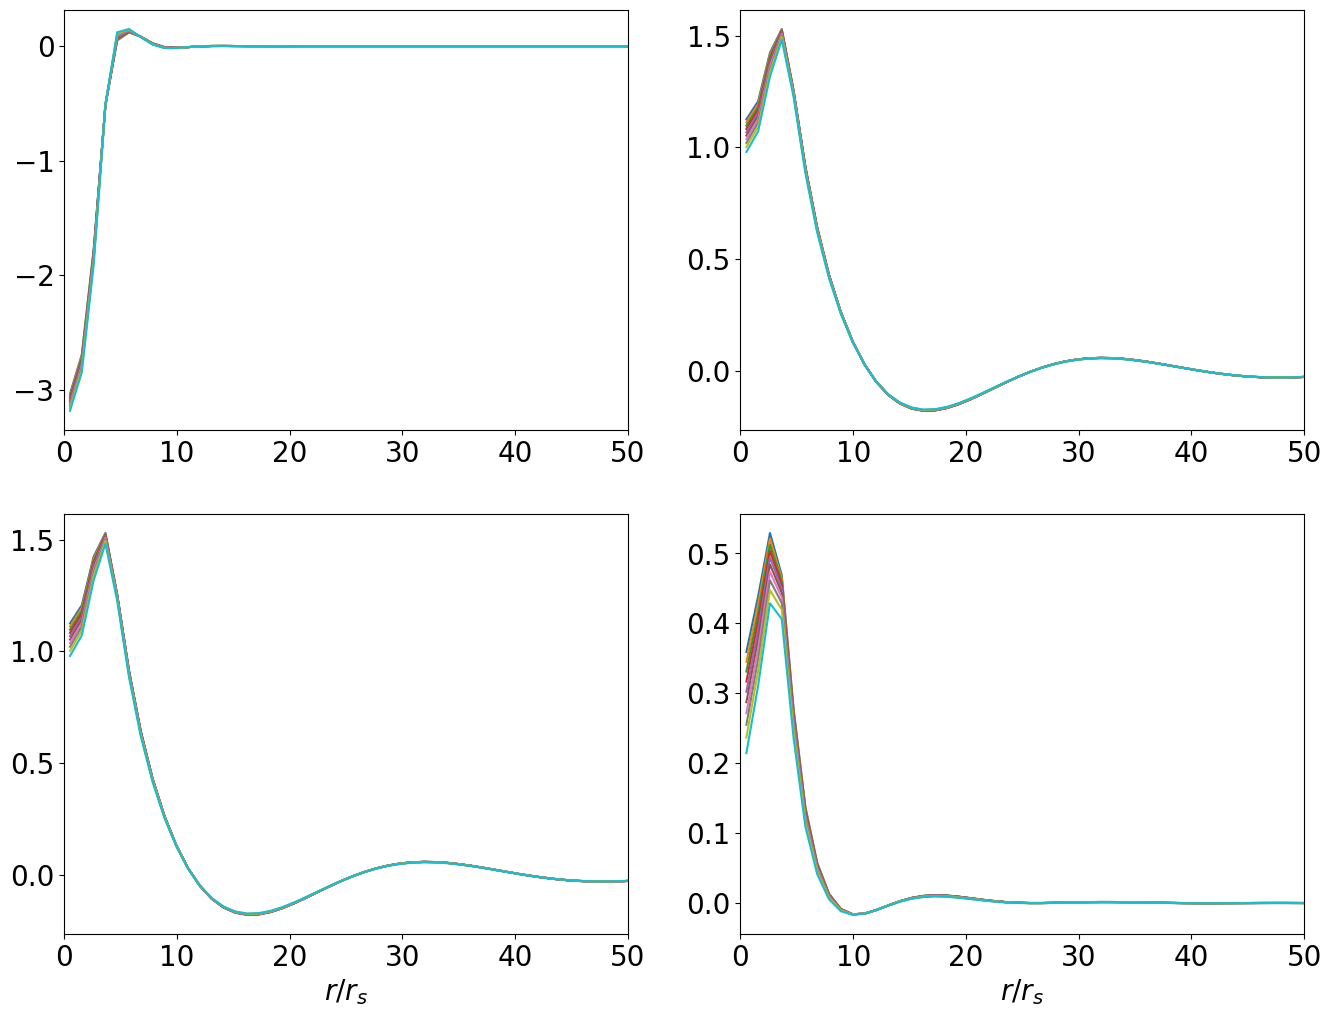

In [15]:
fig, axs = plt.subplots(2,2, figsize=(16,12))




for i in range(2):
        for j in range(2):
            
#             axs[i,j].plot(atom_list[0].k_array, atom_list[0].c_k_matrix[i,j])
#             axs[i,j].plot(atom_test.k_array, atom_test.c_k_matrix[i,j],'--')
            for k in range(10):
                axs[i,j].plot(atom_list[0].k_array, h_k_matrix_list[k][i,j])
#                 axs[i,j].plot(atom_test.k_array, atom_test.c_s_k_matrix[i,j],'--')
            
#             axs[i,j].plot(atom_list[0].k_array, atom_list[0].h_k_matrix[i,j])
#             axs[i,j].plot(atom_list[1].k_array, atom_list[1].h_k_matrix[i,j])
#             axs[i,j].plot(atom_test.k_array, atom_test.h_k_matrix[i,j],'--')

#             axs[i,j].plot(atom_list[0].r_array, atom_list[0].h_r_matrix[i,j])
#             axs[i,j].plot(atom_list[1].r_array, atom_list[1].h_r_matrix[i,j],'--')
#             axs[i,j].plot(atom_test.r_array, atom_test.h_r_matrix[i,j],'--')

            axs[i,j].tick_params(labelsize=20)
#             axs[i,j].set_xscale('log')
            axs[i,j].set_xlim(0,50)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$r/r_s $",fontsize=20)
#             axs[i,j].set_yscale('symlog',linthresh=0.1)
#             axs[i,j].set_ylim(-10, 1e1)

#         axs[i,0].set_ylabel(r"$c(k)$",fontsize=20)

In [ ]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/10)  )

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(8,6))


# ρ_e = [ np.sum(((h_r_matrix[0,1]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]
# ρ_i = [ np.sum(((h_r_matrix[0,0]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]

# ρ_e_normal = [ np.sum(((h_r_matrix[0,1]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom_normal.h_r_matrix_list]
# ρ_i_normal = [ np.sum(((h_r_matrix[0,0]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom_normal.h_r_matrix_list]

# # ax.plot(ρ_e ,label=r'$\rho_e$')#, color=color)
# # ax.plot(ρ_i,  '--', label=r'$\rho_i$')#,color=color)
# ax.plot(ρ_e_normal ,label=r'$\rho_e$')#, color=color)
# ax.plot(ρ_i_normal,  '--', label=r'$\rho_i$')#,color=color)
# ax2 = ax.twinx()
# ax2.plot(atom.u_ex_list,'-k')
# ax2.plot(atom_normal.u_ex_list,'--k')

# # ax.set_ylim(8.75,9.2)
# ax2.set_ylim(-1.5,.1)
# ax.legend()

In [ ]:
atom.plot_species_convergence_ck(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
Al_file = "/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt"  # 1 eV
Al_file = '/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt' # 0.5 eV
Al_data = read_csv(Al_file,header=0, names=['r','g'])

In [ ]:
Te_list[2]/eV

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Al TCCW Case, 1 eV, rs=3', fontsize=20, y=0.95)

ax.plot(Al_data['r'], Al_data['g'],'ro', label = 'VASP' )
# ax.plot(atom.r_array, atom_one_species.h_r_matrix[0,0] + 1, label='No electrons')
ax.plot(atom.r_array, atom.h_r_matrix[0,0] + 1, label='SVT Ashcroft Empy Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT.h_r_matrix[0,0] + 1, label='SVT Ashcroft')
# ax.plot(atom.r_array, atomSVT_Yuk.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT_OCP.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + OCP Bridge')

ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom.invert_HNC([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
luke_r

In [ ]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, R_max)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()